# Notebook to Investigate LSTM Performance Variance by Huc Type

# Step 0 - Set up Notebook

In [46]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg

In [47]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

# Step1 - Get MLFlow Metrics

In [ ]:
# Upload Metrics + Snow Class Data created by Notebook "LSTM_By_Huc_Download_Metrics"
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "single_all_metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

In [ ]:
color_map = {
    "Montane Forest": "orange", 
    "Maritime": "yellow", 
    "Ephemeral": "blue", 
    "Prairie": "red"
}

# Step 2 - Define Plotting Functions 

In [ ]:
def plot_scatter(df_merged, color_map, title="Scatter_Plot_of_Test_KGE_vs_Test_MSE_(Colored_by_Predominant_Snow_Type)", save_local=True, show_legend=True):
    """
    Creates a scatter plot of Test KGE vs Test MSE, colored by Predominant Snow Type.
    
    Parameters:
    - df_merged: DataFrame containing "Test MSE", "Test KGE", and "color" columns.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))
    
    # Use colors directly from the dataframe, default to white if missing
    colors = df_merged["Snow_Type_Color"].fillna("white")
    
    plt.scatter(df_merged["Test MSE"], df_merged["Test KGE"], c=colors, alpha=0.7, edgecolors="k")
    
    # Add labels and title
    plt.xlabel("Test MSE")
    plt.ylabel("Test KGE")
    plt.title(title.replace("_", " "))
    
    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
                   for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()






In [ ]:

def plot_boxplot_by_group(df, parameter, groupby_column="Predominant_Snow", title="Boxplot of Parameter by Group", save_local=True, trunc=False):
    """
    Creates side-by-side box and whisker plots for the given parameter grouped by the specified column.
    
    Parameters:
    - df: DataFrame containing the data to be analyzed.
    - parameter: The column name to be analyzed (e.g., "Test MSE" or "Test KGE").
    - groupby_column: The column name to group by (default: "Predominant_Snow").
    - title: Title of the plot (default: "Boxplot of Parameter by Group").
    - save_local: If True, saves the plot as a PNG file.
    - trunc: If True, truncates x-axis labels to the first 15 characters and rotates them 45 degrees.
    """
    plt.figure(figsize=(10, 6))
    
    # Create boxplot with seaborn
    sns.boxplot(data=df, x=groupby_column, y=parameter, palette="Set2")
    
    # Add labels and title
    plt.xlabel(groupby_column)
    plt.ylabel(parameter)
    plt.title(title.replace("_", " "))
    
    # Truncate x labels and rotate them if trunc is True
    if trunc:
        plt.xticks([i for i in range(len(df[groupby_column].unique()))], 
                   [str(label)[:15] for label in df[groupby_column].unique()], 
                   rotation=90)
    
    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()



In [ ]:
def plot_boxplot_by_two_groups(df, parameter, group_by1="Predominant_Snow", group_by2="Elevation Category", 
                               title="Boxplot of Parameter by Group", save_local=False, trunc=False):
    """
    Creates side-by-side box and whisker plots for the given parameter grouped by two specified columns.
    
    Parameters:
    - df: DataFrame containing the data to be analyzed.
    - parameter: The column name to be analyzed (e.g., "Test MSE" or "Test KGE").
    - group_by1: The primary grouping column (e.g., "Predominant Snow Type").
    - group_by2: The secondary grouping column (e.g., "Elevation Category").
    - title: Title of the plot (default: "Boxplot of Parameter by Group").
    - save_local: If True, saves the plot as a PNG file.
    - trunc: If True, truncates x-axis labels to the first 15 characters and rotates them 45 degrees.
    """
    plt.figure(figsize=(12, 6))
    
    # Define a consistent color palette for group_by1 categories
    unique_categories = df[group_by1].unique()
    palette = dict(zip(unique_categories, sns.color_palette("Set2", len(unique_categories))))
    
    # Create boxplot with seaborn
    sns.boxplot(data=df, x=group_by2, y=parameter, hue=group_by1, palette=palette)

    # Add labels and title
    plt.xlabel(group_by2)
    plt.ylabel(parameter)
    plt.title(title.replace("_", " "))

    # Rotate x labels if trunc is True
    if trunc:
        plt.xticks(rotation=45)

    # Show legend outside the plot
    plt.legend(title=group_by1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()



# Step 3 Create ScatterPlots

In [ ]:
# All results 
plot_scatter(df_metrics, color_map)

In [ ]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
print(df_noE.shape)

In [ ]:
ttl = "Test KGE vs. Test MSE, Excluding Hucs where Ephemeral Snow Predominates"
plot_scatter(df_noE, color_map, title = ttl)

In [ ]:
# Scatterlot by snowtype 

for snowtype in color_map.keys():
    df_st = df_metrics[df_metrics["Predominant_Snow"] == snowtype]
    #print(df_st.head(2))
    ttl = f"Test KGE vs. Test MSE, In HUC12 sub-watershed where {snowtype} Predominates"
    plot_scatter(df_st, color_map, title = ttl, show_legend = False)

# NOTE THAT EACH PLOT HAS A DIFFERENT SCALE IN ORDER TO VISUALIZE DIFFERENCES WITHIN SNOWCLASS 
# BUT CAREFUL RE COMPARING ACCROSS SNOWTYPES USING THE BELOW
    

In [ ]:
# Step 4 - Investigate Individual Hucs w/ KGE and MSE Mismatch

In [ ]:
kge_low_thresh = .7
kge_high_thresh = .9
mse_low_thresh = .001
mse_high_thresh = .02

In [ ]:
def select_sample(df, kge_low_thresh=np.inf, kge_high_thresh=-np.inf, mse_low_thresh=np.inf, mse_high_thresh=-np.inf):
    """
    Selects Huc_Id values that meet the specified threshold conditions.

    Parameters:
    df (pd.DataFrame): The input dataframe with columns "Test MSE", "Test KGE", and "Huc_Id".
    kge_low_thresh (float, optional): Upper bound for "Test KGE" (default: infinity).
    kge_high_thresh (float, optional): Lower bound for "Test KGE" (default: negative infinity).
    mse_low_thresh (float, optional): Upper bound for "Test MSE" (default: infinity).
    mse_high_thresh (float, optional): Lower bound for "Test MSE" (default: negative infinity).

    Returns:
    pd.Series: A Series containing Huc_Id values that meet the conditions.
    """
    filtered_df = df[
        (df["Test MSE"] > mse_high_thresh) & 
        (df["Test MSE"] < mse_low_thresh) & 
        (df["Test KGE"] > kge_high_thresh) & 
        (df["Test KGE"] < kge_low_thresh)
    ]
    
    return filtered_df



# Step 5 - Create box and whisker plot 

In [ ]:
low_low = select_sample(df_noE, kge_low_thresh = kge_low_thresh, mse_low_thresh = mse_low_thresh)
print(low_low.shape)
low_low.head()
# Use 170602071105

In [ ]:
high_low = select_sample(df_noE, kge_high_thresh = kge_high_thresh, mse_low_thresh = mse_low_thresh)
print(high_low.shape)
high_low.head()
# Use 170200090304

In [ ]:
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]
parameter = "Test KGE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
plot_boxplot_by_group(filtered_df, parameter, title= ttl)

In [ ]:
snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]
parameter = "Test KGE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
plot_boxplot_by_group(filtered_df, parameter, title= ttl)

In [ ]:
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]
parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
plot_boxplot_by_group(filtered_df, parameter, title= ttl)

In [ ]:
snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]
parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs (Excludes Ephemeral)"
plot_boxplot_by_group(filtered_df, parameter, title= ttl)

# Step 6 Examine by Basin

In [ ]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Exludes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, trunc = True)

In [ ]:
parameter = "Test MSE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, trunc = True)

In [ ]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Includes Sub-Watersheds)"
plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = groupby, trunc = True)

# Step 7 Examine by Elevation 

In [ ]:
# Define the bins and corresponding labels
bins = [0, 500, 1000, 1500, 2000, float('inf')]
labels = ['low', 'lower mid', 'mid', 'upper mid', 'high']

metrics_w_elev = df_metrics.copy()
# Create the new column 'Elevation Category' based on 'mean_elevation'
metrics_w_elev['Elevation Category'] = pd.cut(metrics_w_elev['mean_elevation'], bins=bins, labels=labels, right=False)

# Display the updated GeoDataFrame
print(metrics_w_elev[['mean_elevation', 'Elevation Category']].head(2))


In [ ]:
# data frame with elevation that excludes ephemeral snow 
metrics_w_elev_noE = filtered_df.copy()
metrics_w_elev_noE['Elevation Category'] = pd.cut(metrics_w_elev_noE['mean_elevation'], bins=bins, labels=labels, right=False)
print(metrics_w_elev_noE[['mean_elevation', 'Elevation Category']].head(2))


In [ ]:
# data frame with elevation that includes only Maritime and Montane Forest 
metrics_MandM = df_metrics.loc[df_metrics["Predominant_Snow"].isin(["Maritime", "Montane Forest"])]

metrics_w_elev_MandM = metrics_MandM.copy()
metrics_w_elev_MandM['Elevation Category'] = pd.cut(metrics_w_elev_MandM['mean_elevation'], bins=bins, labels=labels, right=False)
print(metrics_w_elev_MandM[['mean_elevation', 'Elevation Category']].head(2))


In [ ]:
# Count occurrences of each elevation category
elevation_counts = metrics_w_elev['Elevation Category'].value_counts()

# Print the counts
print(elevation_counts)

In [ ]:
# Create a cross-tabulation of Elevation Category by Predominant Snow Type
elevation_snow_counts = pd.crosstab(metrics_w_elev['Elevation Category'], metrics_w_elev['Predominant_Snow'])

# Print the table
print(elevation_snow_counts)

In [ ]:
parameter = "Test KGE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(metrics_w_elev, parameter, title= ttl, groupby_column = groupby)

In [ ]:
parameter = "Test KGE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(metrics_w_elev_noE, parameter, title= ttl, groupby_column = groupby)

In [45]:
parameter = "MSE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
plot_boxplot_by_group(metrics_w_elev_noE, parameter, title= ttl, groupby_column = groupby)

ValueError: Could not interpret value `MSE` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

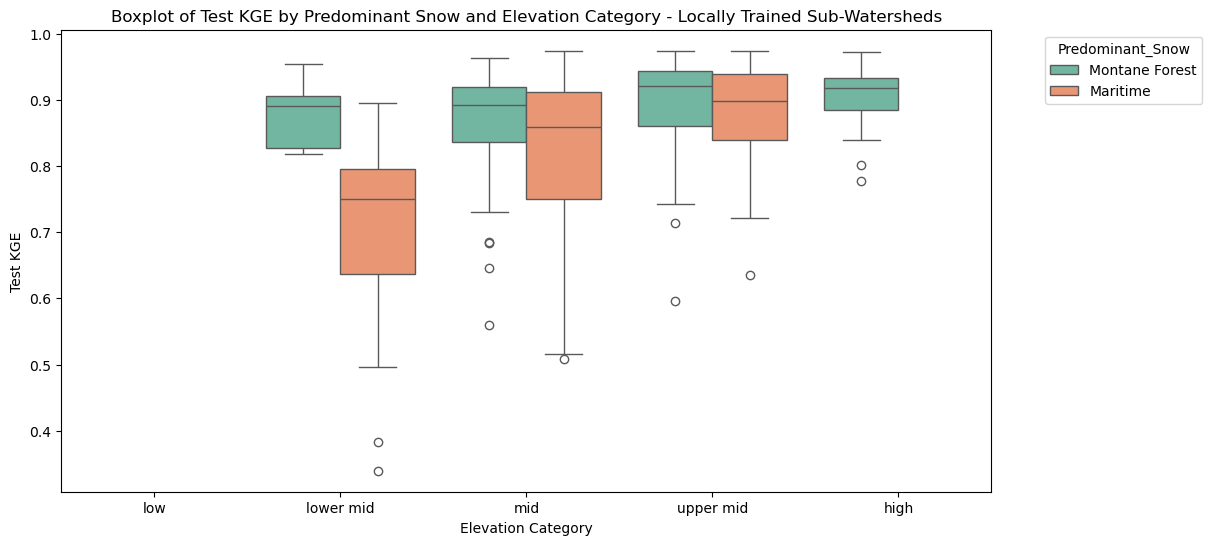

In [26]:
parameter = "Test KGE"
group_by1 = "Predominant_Snow"
group_by2 ="Elevation Category"
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Locally Trained Sub-Watersheds"
plot_boxplot_by_two_groups(metrics_w_elev_MandM, parameter, group_by1=group_by1, group_by2=group_by2, title=ttl)

# Step Last Examine Outliers

In [27]:
# extract the five rows with highest MSE - what do they have in common? 
largest_mse = (df_metrics.nlargest(5, "Test MSE"))
print(largest_mse)

           HUC_ID                    Name  Test MSE  Test KGE  \
435  171100050605  Upper Big Beaver Creek  0.150250  0.547017   
444  171100050707           Goodell Creek  0.075666  0.556022   
456  171100051001  Pass Creek-Baker River  0.063180  0.750787   
478  171100060301              Lime Creek  0.055930  0.508452   
459  171100051004             Swift Creek  0.052678  0.706633   

    Predominant_Snow  mean_elevation    Huc_08     Huc_08_nm  \
435         Maritime     1425.850586  17110005  Upper Skagit   
444         Maritime     1247.895264  17110005  Upper Skagit   
456         Maritime     1342.943848  17110005  Upper Skagit   
478         Maritime     1381.698975  17110006          Sauk   
459         Maritime     1163.793823  17110005  Upper Skagit   

                                              geometry Snow_Type_Color  \
435  POLYGON ((-121.19640523609097 48.8676573291719...          yellow   
444  POLYGON ((-121.33556553927275 48.8170823623381...          yellow   
45

In [28]:
for huc_id in largest_mse["HUC_ID"]:
    geos = gg.get_geos_with_name(huc_id, '12')
    #print(geos)
    largest_mse.loc[largest_mse["HUC_ID"] == huc_id, "Name"] = geos.iloc[0]["name"]
    largest_mse.loc[largest_mse["HUC_ID"] == huc_id, "geometry"] = geos.iloc[0]["geometry"]
largest_mse_gdf = gpd.GeoDataFrame(largest_mse, geometry="geometry")
largest_mse_gdf.set_crs("EPSG:4326", inplace=True) 

largest_mse_gdf

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color
435,171100050605,Upper Big Beaver Creek,0.150250,0.547017,Maritime,1425.850586,17110005,Upper Skagit,"POLYGON ((-121.19641 48.86766, -121.19693 48.8...",yellow,Marginal,darkgray
444,171100050707,Goodell Creek,0.075666,0.556022,Maritime,1247.895264,17110005,Upper Skagit,"POLYGON ((-121.33557 48.81708, -121.33612 48.8...",yellow,Marginal,darkgray
456,171100051001,Pass Creek-Baker River,0.063180,0.750787,Maritime,1342.943848,17110005,Upper Skagit,"POLYGON ((-121.4881 48.8705, -121.48895 48.870...",yellow,Adequate,lightgray
478,171100060301,Lime Creek,0.055930,0.508452,Maritime,1381.698975,17110006,Sauk,"POLYGON ((-121.23134 48.2213, -121.23175 48.22...",yellow,Marginal,darkgray
459,171100051004,Swift Creek,0.052678,0.706633,Maritime,1163.793823,17110005,Upper Skagit,"POLYGON ((-121.60267 48.83158, -121.60272 48.8...",yellow,Adequate,lightgray


In [29]:
largest_mse_gdf.explore()